In [1]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)




#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)




datetime_column = df.columns[0]  # Adjust this if your datetime column isn't the first one

# Add month and week number columns
df_scaled['number_of_the_month'] = df_scaled[datetime_column].dt.month
df_scaled['number_of_the_week'] = df_scaled[datetime_column].dt.isocalendar().week
df_scaled["number_of_the_day"] = df_scaled[datetime_column].dt.isocalendar().day


df_scaled['number_of_the_month'] = df_scaled['number_of_the_month'].astype('float64')
df_scaled['number_of_the_week'] = (df_scaled['number_of_the_week'].astype('float64') % 4) + 1
df_scaled['number_of_the_day'] = df_scaled['number_of_the_day'].astype('float64')

In [3]:
# Şimdi condition=1 olan yerlerin başlangıç ve bitiş noktalarını bulalım
# Bu kez ardışık olmayan tarihler arasındaki farkları dikkate almıyoruz
# Orijinal indeksleri tutalım ki ardışık olmayan noktaları tespit edebilelim
condition_1_with_index = df[df['condition'] == 1].reset_index()

# Ardışık olmayan indeksler arasındaki farkları hesaplayalım
condition_1_with_index['index_diff'] = condition_1_with_index['index'].diff()

# Ardışık olmayan kayıtlar için (indeks farkı 1'den büyükse) yeni grup oluştur
condition_1_with_index['group'] = (condition_1_with_index['index_diff'] > 1).cumsum()

# Her grup için başlangıç ve bitiş tarihlerini bulalım
result = condition_1_with_index.groupby('group').agg({'timestamp': ['min', 'max']})
result.columns = ['start_date', 'end_date']
result = result.reset_index(drop=True)

print("\nCondition 1 olan tarih aralıkları:")
print(result)


Condition 1 olan tarih aralıkları:
           start_date            end_date
0 2020-04-18 00:00:01 2020-04-18 23:58:56
1 2020-05-29 23:30:08 2020-05-30 05:59:54
2 2020-06-05 10:00:04 2020-06-07 14:19:39
3 2020-07-15 14:30:00 2020-07-15 19:00:00


In [4]:
def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount, graph):


    result1 = mpt.get_the_probabilities_with_random_forest_new_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4, graph)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)

    feature_importances = result1[2]

    return result, feature_importances, y_test


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    print(1)
    print(df)

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [5]:
df_back_up = df_scaled.copy()

In [6]:
df = df_back_up.copy()

df1 = df.copy() # best but suspicious

Variable Selection

In [7]:
n_ = [5, 10, 25]

d_ = [5,10,20]

s_ = [20,30,40]

l_ = [20,30,40]

                       Importance
DV_pressure          6.056182e-01
TP2                  1.092236e-01
Oil_temperature      1.039178e-01
number_of_the_day    6.230606e-02
Motor_current        5.552833e-02
H1                   4.607196e-02
Reservoirs           1.132146e-02
TP3                  3.304073e-03
number_of_the_month  2.707467e-03
Towers               1.033194e-06
Oil_level            3.133606e-08
COMP                 0.000000e+00
DV_eletric           0.000000e+00
MPG                  0.000000e+00
LPS                  0.000000e+00
Pressure_switch      0.000000e+00
Caudal_impulses      0.000000e+00
number_of_the_week   0.000000e+00
R-squareddd: 0.9954844042458902
F-Value Like: 1228716.6376006762
model preditions
[0 0 0 ... 0 0 0]
model proba
[0. 0. 0. ... 0. 0. 0.]
        model_predictions  model_probablities
0                       0                 0.0
1                       0                 0.0
2                       0                 0.0
3                       0         

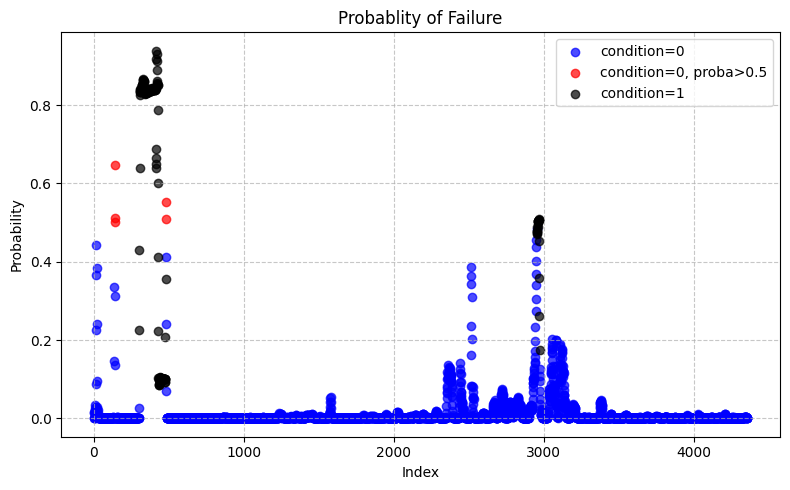

In [8]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df1

aggregated_probabilities, f2, y_test = agg_random_forest(10, 10, 10, 35, 45, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 18, "yes", "yes", "no", "no", 100, "no")

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

In [9]:
aggregated_probabilities[aggregated_probabilities["condition"] > 0]

,group_id,start_row,end_row,row_count,proba,condition
302,302,30200,30599,400,0.224824,1
303,303,30300,30699,400,0.430804,1
304,304,30400,30799,400,0.639314,1
305,305,30500,30899,400,0.826464,1
306,306,30600,30999,400,0.833997,1
...,...,...,...,...,...,...
2967,2967,296700,297099,400,0.505990,1
2968,2968,296800,297199,400,0.452370,1
2969,2969,296900,297299,400,0.358455,1
2970,2970,297000,297399,400,0.260338,1


In [10]:
df1.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses',
       'condition', 'number_of_the_month', 'number_of_the_week',
       'number_of_the_day'],
      dtype='object')

In [79]:
iteration = 0

f = f2

for i in n_:
    for j in d_:
        for k in s_:
            for l in l_:

                iteration += 1
                print(iteration)
                print()
                print(i,j,k,l)


                aggregation_size = 400

                treshold_probability = 0.5

                dataframe = df1

                aggregated_probabilities, f1, a = agg_random_forest(10, 15, 10, 10, 10, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 18, "yes", "yes", "no", "no", 100, "no")

                f += f1

1

5 5 20 20
                       Importance
DV_pressure          8.932082e-01
number_of_the_day    7.504391e-02
Oil_temperature      2.840315e-02
Motor_current        1.183710e-03
Reservoirs           9.204306e-04
TP3                  6.966746e-04
number_of_the_month  1.875688e-04
TP2                  1.410575e-04
H1                   1.078356e-04
DV_eletric           4.600680e-05
COMP                 3.067952e-05
MPG                  3.065782e-05
Caudal_impulses      1.205117e-07
LPS                  0.000000e+00
Pressure_switch      0.000000e+00
Oil_level            0.000000e+00
number_of_the_week   0.000000e+00
Towers               0.000000e+00
R-squareddd: 0.9980162921882346
F-Value Like: 2804092.0224588397
model preditions
[0 0 0 ... 0 0 0]
model proba
[0. 0. 0. ... 0. 0. 0.]
        model_predictions  model_probablities
0                       0                 0.0
1                       0                 0.0
2                       0                 0.0
3                    

In [80]:
f.sort_values(by='Importance', ascending=False)

,Importance
DV_pressure,7.295548e+01
number_of_the_day,6.140863e+00
Oil_temperature,2.404573e+00
Motor_current,1.514088e-01
TP2,1.206492e-01
Reservoirs,8.587634e-02
TP3,5.973472e-02
H1,5.480665e-02
number_of_the_month,1.790054e-02
DV_eletric,3.726551e-03


                     Importance
DV_pressure            0.897648
number_of_the_day      0.073736
Oil_temperature        0.026687
H1                     0.001783
Reservoirs             0.000132
Motor_current          0.000013
number_of_the_month    0.000000
R-squareddd: 0.9935900237944845
F-Value Like: 2221801.3172217123
model preditions
[0 0 0 ... 0 0 0]
model proba
[8.08385654e-06 8.08385654e-06 8.08385654e-06 ... 1.56715507e-04
 1.56715507e-04 1.56715507e-04]
        model_predictions  model_probablities
0                       0            0.000008
1                       0            0.000008
2                       0            0.000008
3                       0            0.000008
4                       0            0.000008
...                   ...                 ...
435981                  0            0.000157
435982                  0            0.000157
435983                  0            0.000157
435984                  0            0.000157
435985                  0    

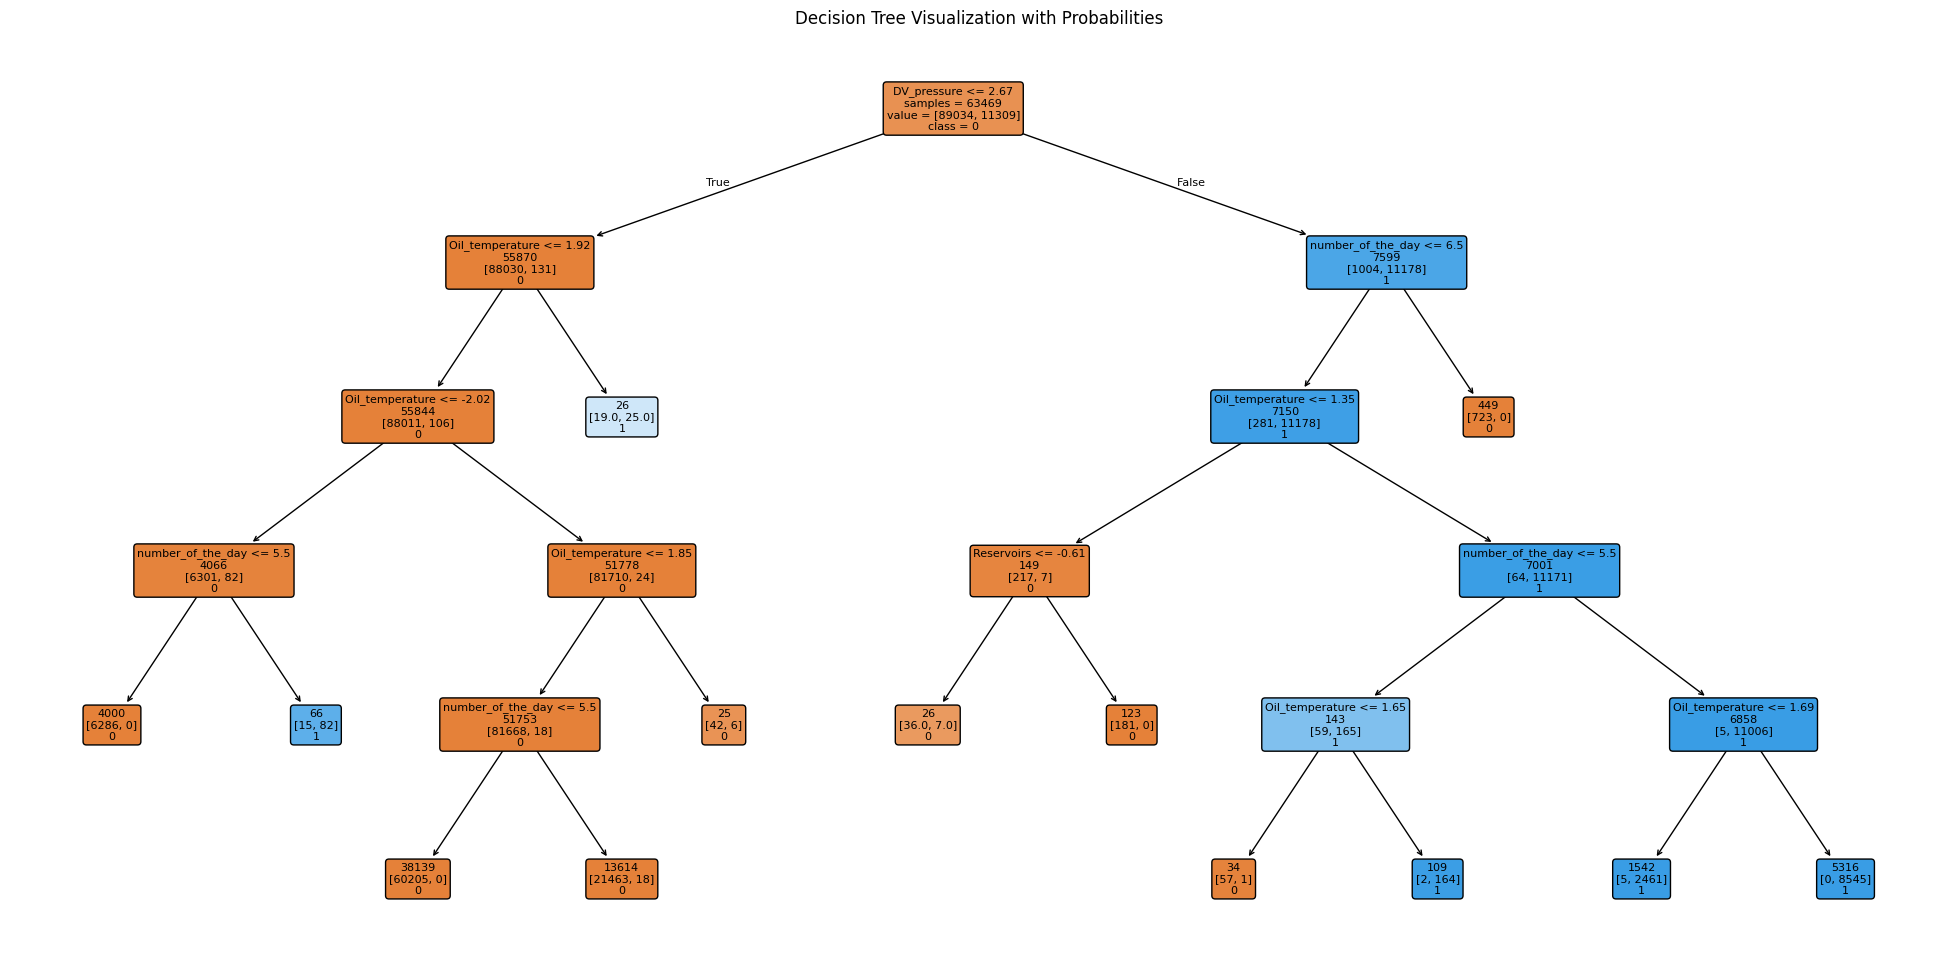

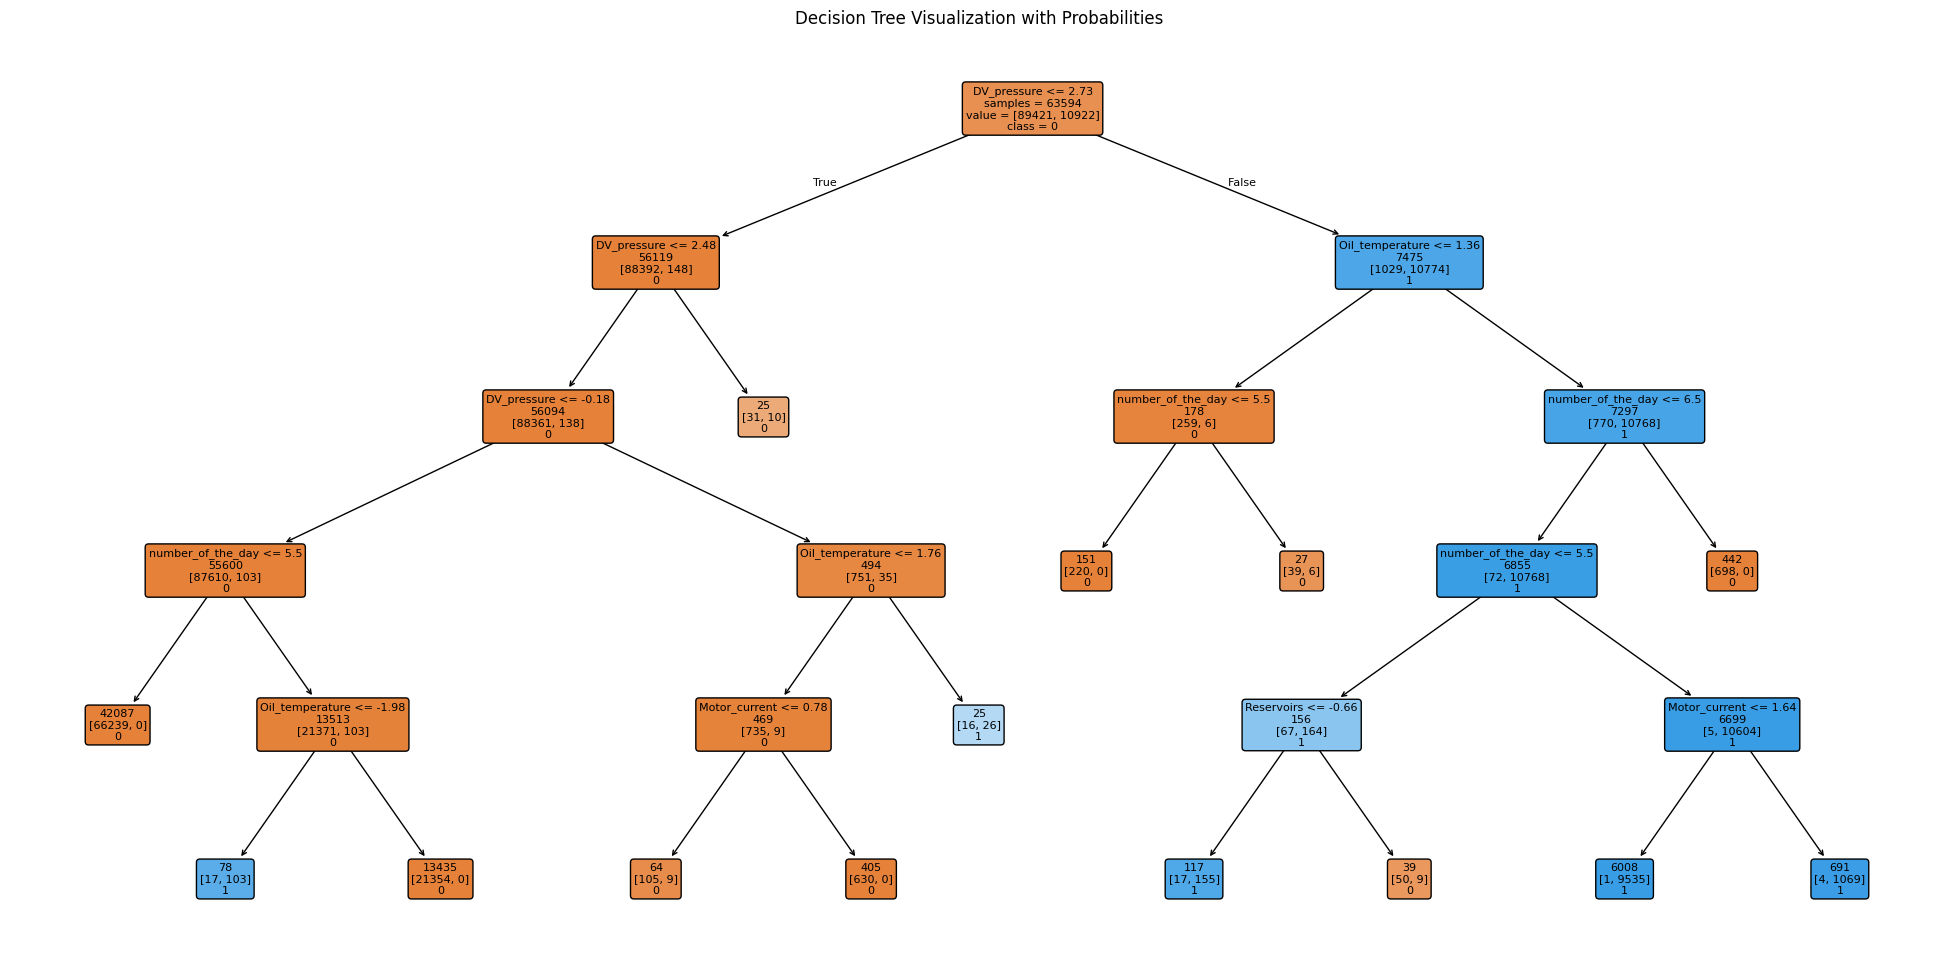

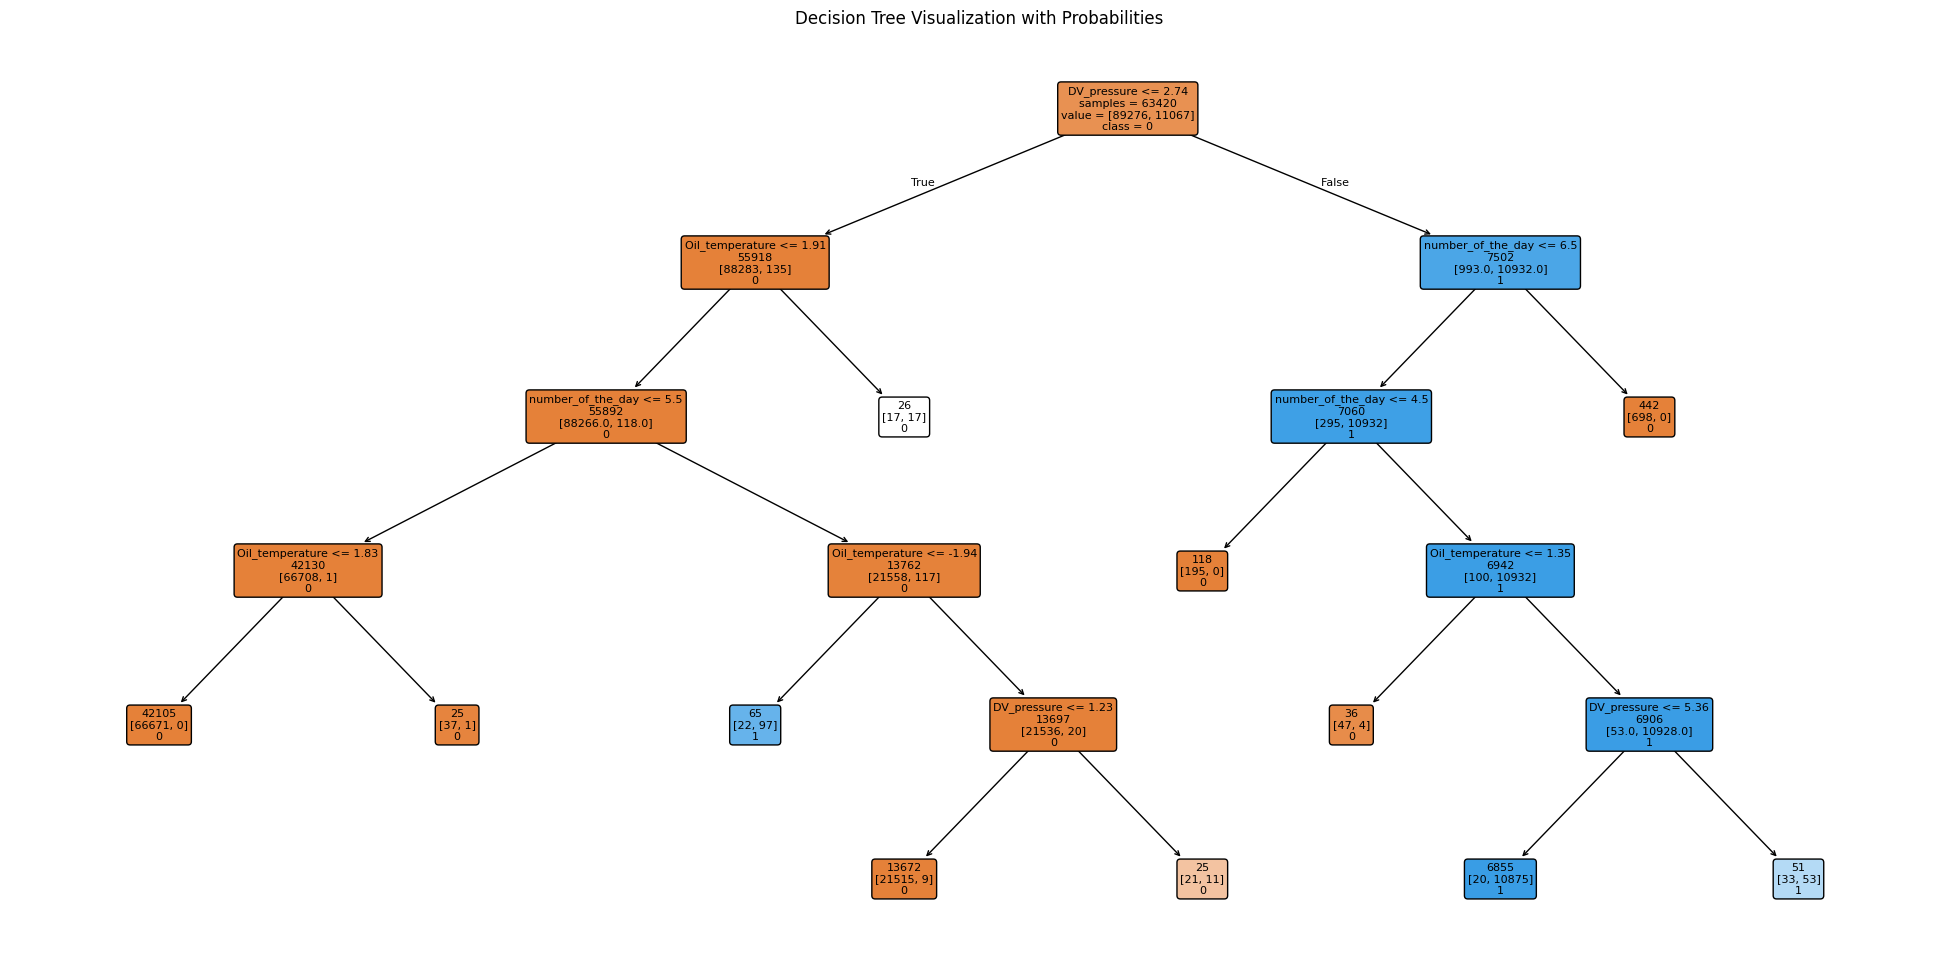

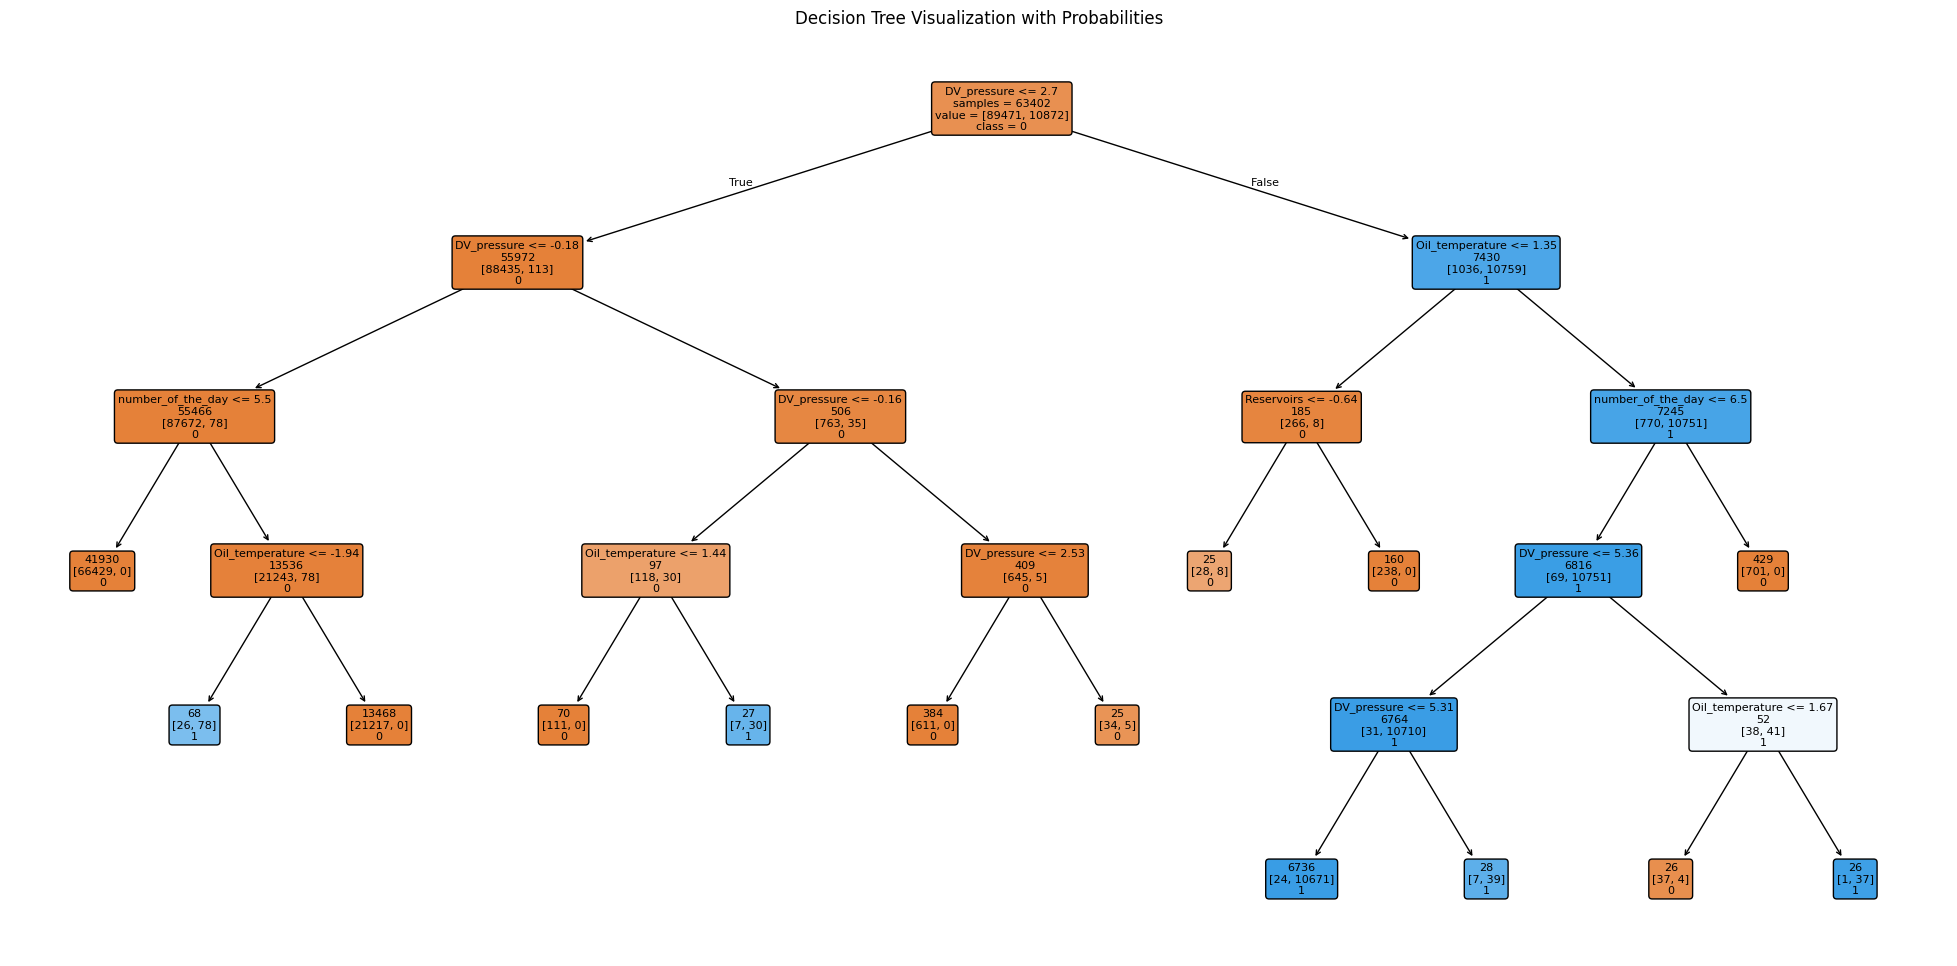

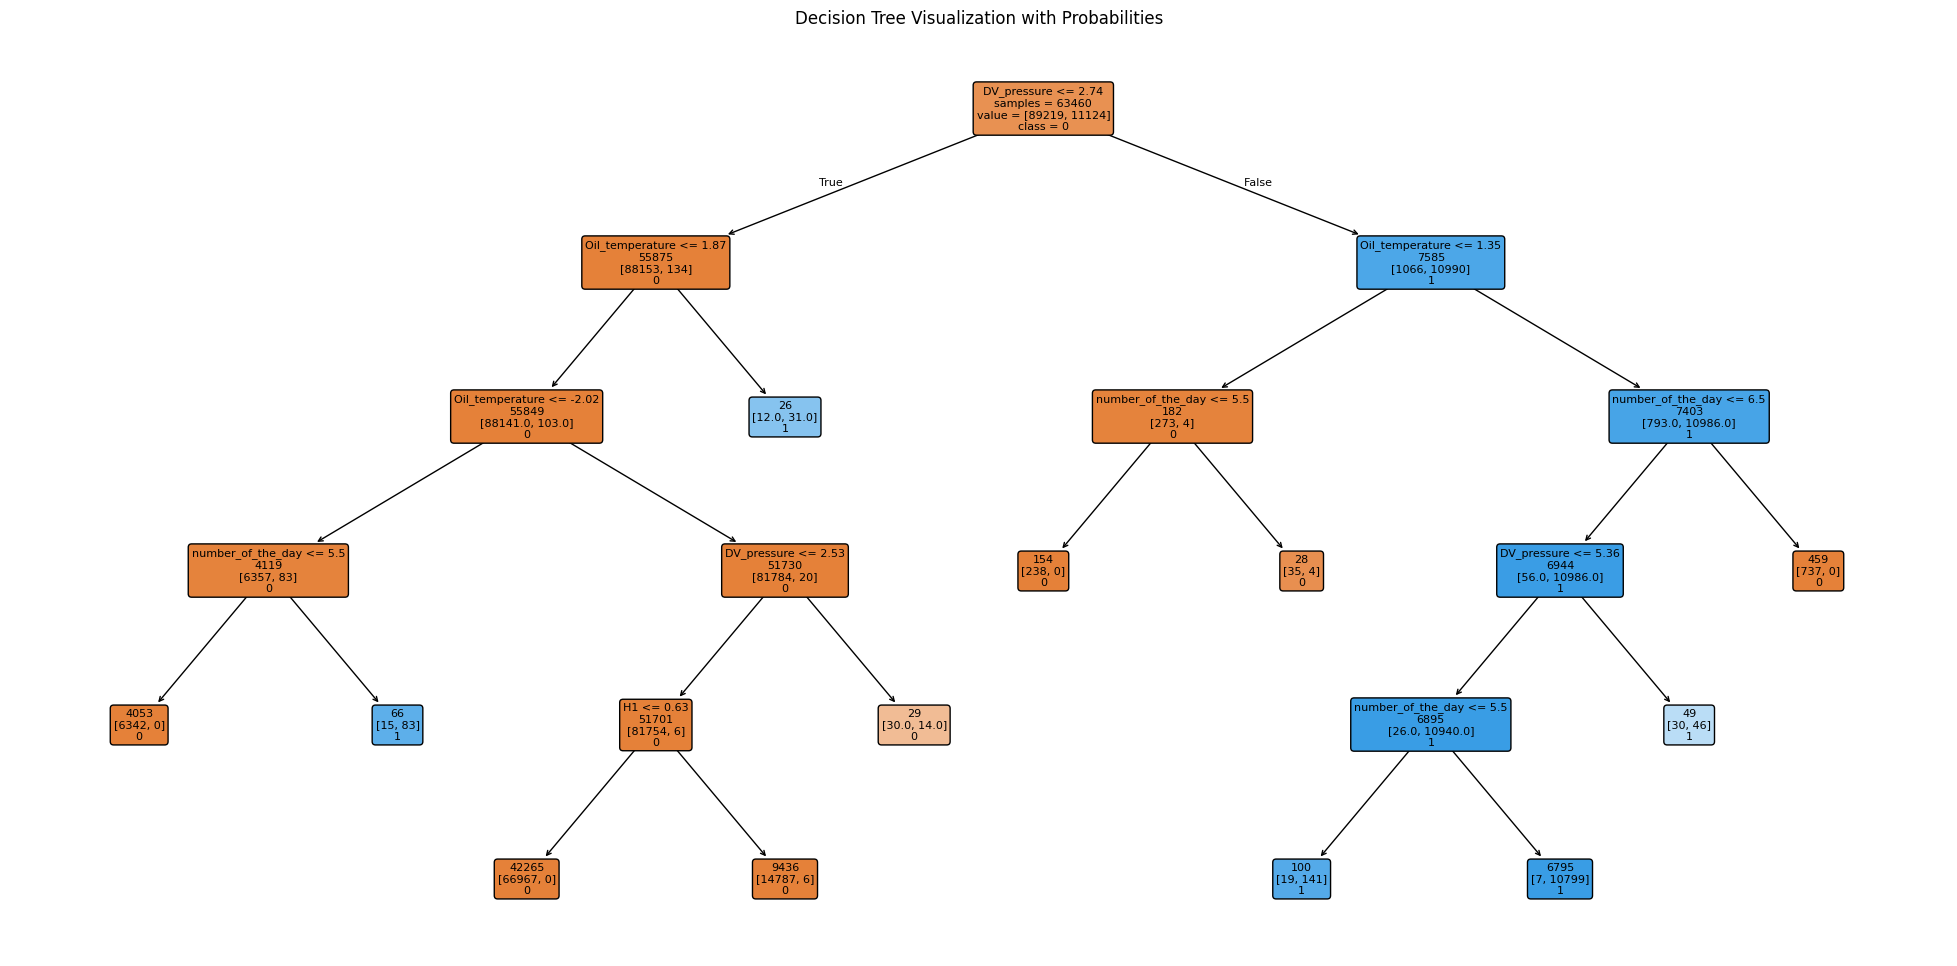

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000044          0
1            1        100      499        400  0.000032          0
2            2        200      599        400  0.014633          0
3            3        300      699        400  0.016686          0
4            4        400      799        400  0.023645          0
...        ...        ...      ...        ...       ...        ...
4352      4352     435200   435599        400  0.000273          0
4353      4353     435300   435699        400  0.000276          0
4354      4354     435400   435799        400  0.000283          0
4355      4355     435500   435899        400  0.000670          0
4356      4356     435600   435985        386  0.000787          0

[4357 rows x 6 columns]


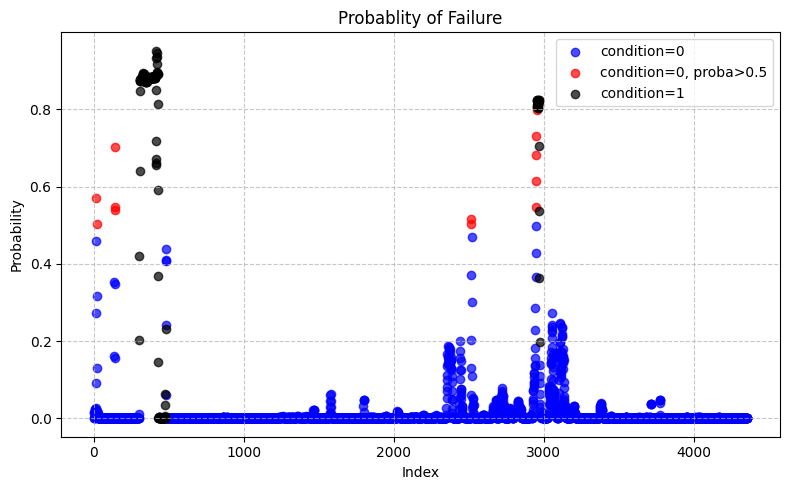

In [11]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df

dataframe = dataframe.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)


df2 = dataframe

aggregated_probabilities, f2, a= agg_random_forest(5, 5, 5, 10, 25, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 18, "yes", "yes", "no", "no", 100, "yes")

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

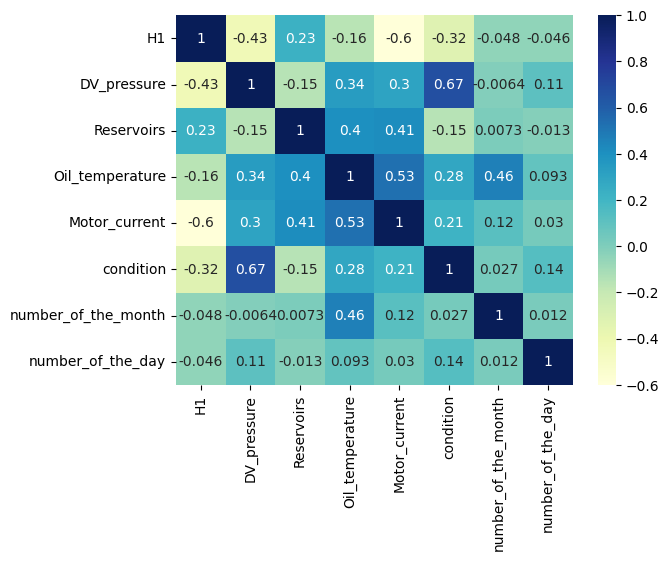

In [12]:
co_mtx = df2.corr(numeric_only=True)
sns.heatmap(co_mtx, cmap="YlGnBu", annot=True)
plt.show()

Metric Selection

In [13]:
aggregated_probabilities

,group_id,start_row,end_row,row_count,proba,condition
0,0,0,399,400,0.000044,0
1,1,100,499,400,0.000032,0
2,2,200,599,400,0.014633,0
3,3,300,699,400,0.016686,0
4,4,400,799,400,0.023645,0
...,...,...,...,...,...,...
4352,4352,435200,435599,400,0.000273,0
4353,4353,435300,435699,400,0.000276,0
4354,4354,435400,435799,400,0.000283,0
4355,4355,435500,435899,400,0.000670,0


In [14]:
print(aggregated_probabilities[aggregated_probabilities["condition"] > 0])

      group_id  start_row  end_row  row_count     proba  condition
302        302      30200    30599        400  0.203879          1
303        303      30300    30699        400  0.420812          1
304        304      30400    30799        400  0.639085          1
305        305      30500    30899        400  0.848304          1
306        306      30600    30999        400  0.873571          1
...        ...        ...      ...        ...       ...        ...
2967      2967     296700   297099        400  0.824323          1
2968      2968     296800   297199        400  0.704278          1
2969      2969     296900   297299        400  0.535806          1
2970      2970     297000   297399        400  0.363307          1
2971      2971     297100   297499        400  0.198314          1

[197 rows x 6 columns]


In [15]:
# 302 478 arası ve 
print(aggregated_probabilities[aggregated_probabilities["condition"] > 0].loc[478])

group_id       478.000000
start_row    47800.000000
end_row      48199.000000
row_count      400.000000
proba            0.232246
condition        1.000000
Name: 478, dtype: float64


In [16]:
def calculate_scores(df):
    
    # Condition değeri 1 olan satırları bul
    condition_1_rows = df[df['condition'] == 1].index.tolist()
    
    if not condition_1_rows:
        print("Condition değeri 1 olan satır bulunamadı.")
        return
    
    # Condition 1 olan grupları bul
    groups = []
    current_group = [condition_1_rows[0]]
    
    for i in range(1, len(condition_1_rows)):
        # Eğer ardışık indeksler ise aynı gruba ekle
        if condition_1_rows[i] == condition_1_rows[i-1] + 1:
            current_group.append(condition_1_rows[i])
        else:
            # Değilse yeni grup başlat
            groups.append(current_group)
            current_group = [condition_1_rows[i]]
    
    # Son grubu eklemeyi unutma
    if current_group:
        groups.append(current_group)
    
    # Early score hesaplama (her grup için ilk 1'den önceki 75 satır)
    early_score = 0
    early_rows_count = 0
    
    for group in groups:
        # Gruptaki ilk 1'in indeksi
        first_one_idx = group[0]
        # İlk 1'den önceki 75 satır (ya da mümkün olan maksimum)
        start_idx = max(0, first_one_idx - 400)
        rows_to_consider = df.iloc[start_idx:first_one_idx]

        for _, row in rows_to_consider.iterrows():
            if row['proba'] > 0.5:
                early_score += (row['proba'] - 0.45)
                early_rows_count += 1

    # False score hesaplama (condition=0 ve proba>0.4 olan yerler için)
    false_score = 0
    false_rows_count = 0
    condition_0_rows = df[df['condition'] == 0]
    
    for _, row in condition_0_rows.iterrows():
        if row['proba'] > 0.5:
            # 0.4'ü aşan kısmı topla
            false_score += (row['proba'] - 0.45)
            false_rows_count += 1


    false_score = -1*false_score + early_score
    # Sonuçları yazdır
    print(f"Early Score: {early_score:.6f} (kullanılan satır sayısı: {early_rows_count})")
    print(f"False Score: {false_score:.6f} (kullanılan satır sayısı: {false_rows_count})")
    
    return early_score, false_score

In [17]:
calculate_scores(aggregated_probabilities)

Early Score: 1.734829 (kullanılan satır sayısı: 10)
False Score: -0.121243 (kullanılan satır sayısı: 12)


(np.float64(1.7348285638661327), np.float64(-0.12124293828984967))

Hyperparameter Selection

In [112]:
def fit_the_model_and_get_the_best_scores(n_, d_, l_):

    score1_best = -100
    score2_best = -100
    total_score_best = -100

    best_set1 = []
    best_set2 = []
    best_set3 = []

    iteration = 0

    for i in n_:
        for j in d_:
            for k in l_:
                    
                    iteration += 1
                    print(iteration)
                    print()
                    print(i,j,k*2 ,k)

                    


                    aggregation_size = 400

                    treshold_probability = 0.5

                    dataframe = df2

                    aggregated_probabilities, f1, a= agg_random_forest(i, 5, j, k*2, k, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 18, "yes", "yes", "no", "no", 100, "no")

                    score1, score2 = calculate_scores(aggregated_probabilities)

                    total_score = score1 + score2

                    if total_score > total_score_best:

                        total_score_best = total_score
                        best_set1 = [iteration, i, j, k*2 , k]
                        print("better is found for total")

                    if score1 > score1_best:

                        score1_best = score1
                        best_set2 = [iteration, i, j, k*2 , k]
                        print("better is found for 1")

                    if score2 > score2_best:

                        score2_best = score2
                        best_set3 = [iteration, i, j, k*2 , k]
                        print("better is found for 2")

                    print()
                    print("********************************************************************")
                    print()

    print(best_set1, total_score_best)
    print(best_set2, score1_best)
    print(best_set3, score2_best)
    return


                

In [113]:
n_ = [5, 10, 25]#25, 50, 100]
d_ = [5, 10, 50] #25, 50, 100]
l_ = [30, 40, 50]

In [114]:
fit_the_model_and_get_the_best_scores(n_, d_, l_)

1

5 5 60 30
                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[8.08396545e-06 8.08396545e-06 8.08396545e-06 ... 1.56715616e-04
 1.56715616e-04 1.56715616e-04]
        model_predictions  model_probablities
0                       0            0.000008
1                       0            0.000008
2                       0            0.000008
3                       0            0.000008
4                       0            0.000008
...                   ...                 ...
435981                  0            0.000157
435982                  0            0.000157
435983                  0            0.000157
435984                  0            0.000157
435985           

In [115]:
def fit_the_model(i, j, k, l):
    
    aggregation_size = 400

    treshold_probability = 0.5

    dataframe = df2

    aggregated_probabilities, f1, a = agg_random_forest(i, 5, j, k, l, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 30, "yes", "yes", "no", "no", 100, "yes")

    plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[8.08396545e-06 8.08396545e-06 8.08396545e-06 ... 8.08396545e-06
 8.08396545e-06 8.08396545e-06]
        model_predictions  model_probablities
0                       0            0.000008
1                       0            0.000008
2                       0            0.000008
3                       0            0.000008
4                       0            0.000008
...                   ...                 ...
521846                  0            0.000008
521847                  0            0.000008
521848                  0            0.000008
521849                  0            0.000008
521850                  0     

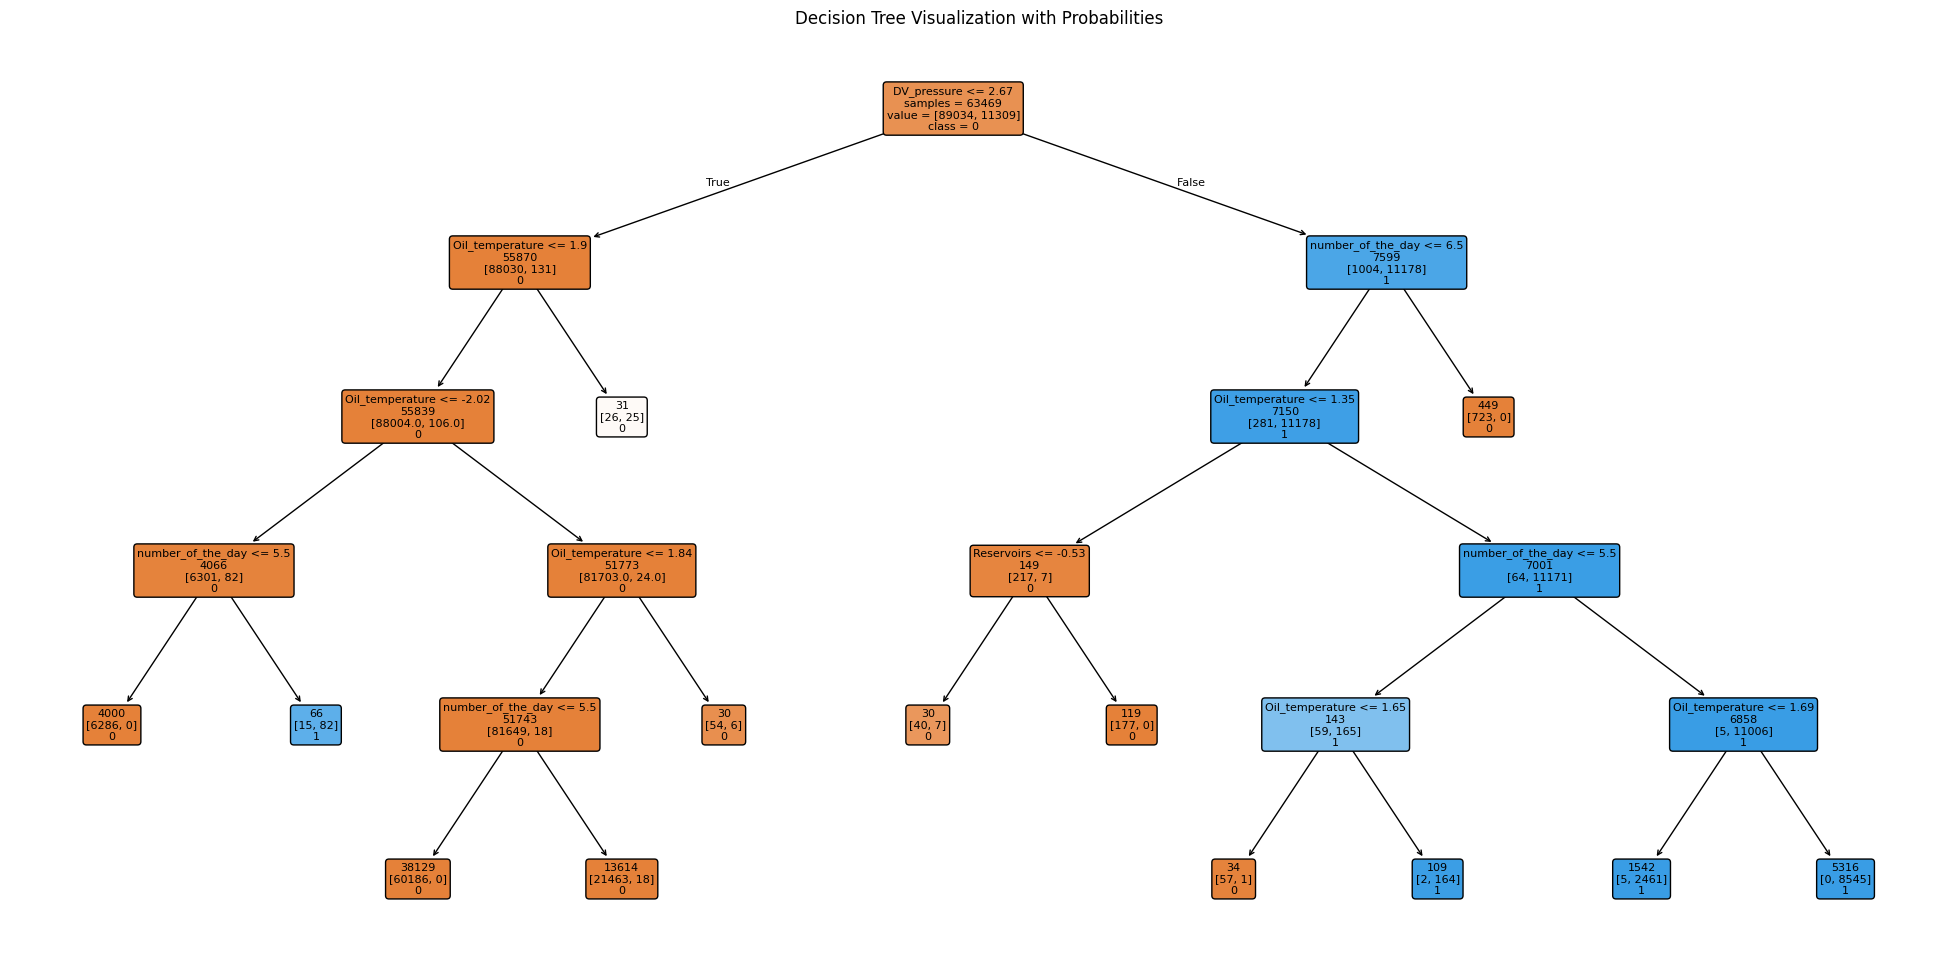

1
      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000038          0
1            1        100      499        400  0.000028          0
2            2        200      599        400  0.013579          0
3            3        300      699        400  0.016594          0
4            4        400      799        400  0.025245          0
...        ...        ...      ...        ...       ...        ...
5211      5211     521100   521499        400  0.000356          0
5212      5212     521200   521599        400  0.000042          0
5213      5213     521300   521699        400  0.002768          0
5214      5214     521400   521799        400  0.002775          0
5215      5215     521500   521850        351  0.003161          0

[5216 rows x 6 columns]


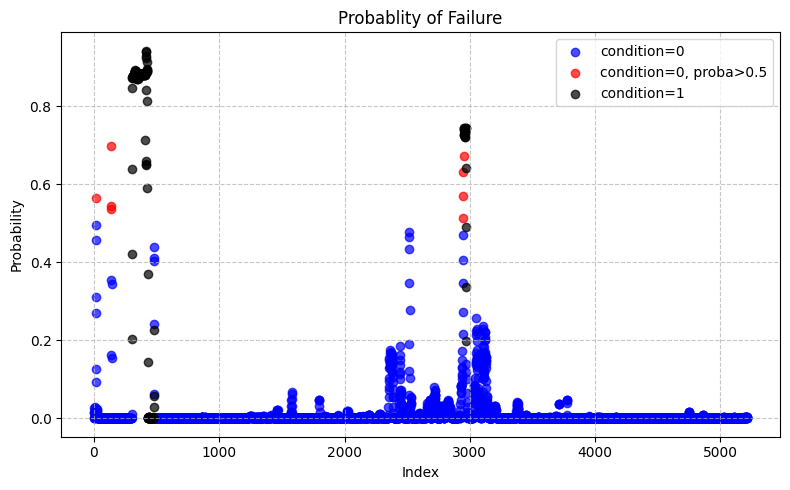

In [116]:
fit_the_model(5, 5, 60, 30)

In [29]:
def fit_the_model_and_get_the_best_scores2(n_, d_, l_):

    score1_best = -100
    score2_best = -100
    total_score_best = -100

    best_set1 = []
    best_set2 = []
    best_set3 = []

    iteration = 0

    for i in n_:
        for j in d_:
            for k in l_:
                    
                    iteration += 1
                    print(iteration)
                    print()
                    print(i,j,k*2 ,k)

                    


                    aggregation_size = 400

                    treshold_probability = 0.5

                    dataframe = df2

                    aggregated_probabilities, f1, a= agg_random_forest(i, 5, j, k*2, k, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 18, "yes", "yes", "no", "no", 100, "no")

                    score1, score2 = calculate_scores(aggregated_probabilities)

                    total_score = score1 + score2

                    if score2 > -0.15:

                        if total_score > total_score_best:

                            total_score_best = total_score
                            best_set1 = [iteration, i, j, k*2 , k]
                            print("better is found for total")

                        if score1 > score1_best:

                            score1_best = score1
                            best_set2 = [iteration, i, j, k*2 , k]
                            print("better is found for 1")

                        if score2 > score2_best:

                            score2_best = score2
                            best_set3 = [iteration, i, j, k*2 , k]
                            print("better is found for 2")

                        print()
                        print("********************************************************************")
                        print()

    print(best_set1, total_score_best)
    print(best_set2, score1_best)
    print(best_set3, score2_best)
    return


                

In [30]:
n_ = [5, 10]#25, 50, 100]
d_ = [5, 25] #25, 50, 100]
l_ = [30, 40, 50, 75]

In [31]:
fit_the_model_and_get_the_best_scores2(n_, d_, l_)

1

5 5 60 30
                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[8.08396545e-06 8.08396545e-06 8.08396545e-06 ... 1.56715616e-04
 1.56715616e-04 1.56715616e-04]
        model_predictions  model_probablities
0                       0            0.000008
1                       0            0.000008
2                       0            0.000008
3                       0            0.000008
4                       0            0.000008
...                   ...                 ...
435981                  0            0.000157
435982                  0            0.000157
435983                  0            0.000157
435984                  0            0.000157
435985           